# Tuto 005 : Introduction to friction

This tutorial is an introduction to friction mechanism. It aims at introducing the friction elements present in pyHarm by letting the user code a simple first friction model. The tutorial comprises 2 main parts : 
1. Build the base problem of the tutorial and make the linear analysis
2. Construction of a friction element based on a smooth Coulomb model and application to a single mass damper technology.



In [1]:
## This block makes the mandatory imports and configure matplotlib for figures
## Some help function is also define here (get_frf)
import sys
PATH_TO_PYHARM = False
PATH_TO_PYHARM = "../"
if PATH_TO_PYHARM !=False : 
    sys.path.append(PATH_TO_PYHARM)
# ------------------ IMPORTS ------------------ #
import copy
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyHarm
import json
import scipy.io
from pyHarm.Elements.FactoryElements import ElementDictionary
from pyHarm.Elements.ABCElement import ABCElement

# ------------------ MATPLOTLIB DEFAULT STYLE ------------------ #
plt.style.use('default')
FONT_BASE = 25
width_fig = 15
ratio_fig = (width_fig,1/(16/10.)*width_fig)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
plt.rc('xtick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_BASE)    # legend fontsize
plt.rc('axes', labelsize=FONT_BASE)
plt.rc('axes', titlesize=FONT_BASE+5) #fontsize of the title

BASE_CMAP_NAME = "RdYlGn_r"
BASE_CMAP = cm.get_cmap(BASE_CMAP_NAME, 2)


style_plots_ref = {"frf_lin":{"linestyle":"dashed","color":np.zeros(3,),\
                          "label":"Linear solution","linewidth":3},\
                   "frf_lin_slide":{"linestyle":"dashed","color":BASE_CMAP(0),\
                          "label":"Linear solution sliding","linewidth":3},\
                   "frf_lin_stuck":{"linestyle":"dashed","color":BASE_CMAP(1),\
                          "label":"Linear solution stuck","linewidth":3},\
                   "frf_fric":{"linestyle":"solid","linewidth":2,"color":np.array([0,140,255])/255.,\
                           "marker":None},\
                  }
SAVE = False

# ------------------ helper functions ------------------ #
def get_frf(M,indices_selection=('sub1', 0, 0),analysis="FRF"): 
    indexH = M.getIndex(*indices_selection)
    SA = [sol for sol in M.nls[analysis].SolList if sol.flag_accepted]
    om = np.array([sol.x[-1] for sol in SA])
    ampH = np.array([np.linalg.norm(sol.x[indexH]) for sol in SA])
    return SA,om,ampH


def prep_fig(fp):
    fig,ax = plt.subplots(figsize=ratio_fig)
    ax.set_xticks(fp)
    ax.set_xticklabels([f"{f:.2e}" for f in fp])
    ax.grid()
    ax.set_yscale("log")
    return fig,ax

## 1. Build the base problem and make the linear analysis

The problem studied is this tutorial is the damping through friction applied to a single mass oscillator. In this part of the tutorial, the single mass oscillator as well as the added mass that will later be in friction contact for damping purpose is built. Linear analysis under different hypothesis will allow us to understand the response of our future damper.


### 1.1 Linear response of a simple lumped mass model

In the next block a single mass problem is built and an input template is proposed. First the linear response of this simple mass is made around its natural mode.

- Complete the `get_resonance` that returns the natural frequency of the single mass

In [2]:
from Tuto_005_IntroductionToFriction_correctionfunctions import get_resonance_corr
PULSATION_DELTA = 2.
mass_lm = 1.
vdamp_lm = 5e-2
rigid_lm = 640.

LumpedMass = dict()
LumpedMass["M"] = mass_lm * np.ones((1,1))
LumpedMass["C"] = vdamp_lm * np.ones((1,1))
LumpedMass["K"] = rigid_lm * np.ones((1,1))
LumpedMass["G"] = np.zeros((1,1))

### USER MODIFICATIONS
def get_resonance(mass:float,rigidity:float) -> float:
    """functions that returns the natural frequency of the single mass problem
    defined by its rigidity and mass value"""
    fp = 0.
    return fp
### END

freq_resonance = get_resonance_corr(mass_lm,rigid_lm)
puls_resonance = (2*np.pi) * freq_resonance
puls_inf = puls_resonance - PULSATION_DELTA
puls_sup = puls_resonance + PULSATION_DELTA


# ------------------ INPUT CONSTRUCTION ------------------ #
INP = \
{
    "analysis": {"FRF":{
                "study":"frf",
                "puls_inf":puls_inf,
                "puls_sup":puls_sup,
                "ds_max": 5e-3,
                "sign_ds": 1,
                "verbose":True,
                "predictor_options": {"verbose":False, "norm":"om"}
             }},
    "system":{"type":"Base",
              "nh":1,
              "nti":128},

    "substructures": {
                "sub1": {
                    "matrix": LumpedMass,
                    "ndofs" : 1
                }
            },
    "connectors": {
        "loading" : {
            "type":"CosinusForcing",
            "connect":{"sub1":[0]},
            "dirs":[0],
            "amp":1.,
        }
        },


}

Lin = pyHarm.Maestro(INP)
Lin.operate()

solution converged at om=23.298221281347036
solution converged at om=23.30322128104135
solution converged at om=23.308221280731807
solution converged at om=23.313221280418354
solution converged at om=23.318221280100925
solution converged at om=23.323221279779464
solution converged at om=23.32822127945391
solution converged at om=23.333221279124196
solution converged at om=23.33822127879026
solution converged at om=23.34322127845204
solution converged at om=23.34822127810947
solution converged at om=23.35322127776248
solution converged at om=23.358221277410998
solution converged at om=23.363221277054958
solution converged at om=23.36822127669429
solution converged at om=23.37322127632892
solution converged at om=23.378221275958776
solution converged at om=23.38322127558378
solution converged at om=23.388221275203858
solution converged at om=23.39322127481893
solution converged at om=23.39822127442892
solution converged at om=23.403221274033744
solution converged at om=23.40822127363332


solution converged at om=24.52821993413347
solution converged at om=24.53321989786285
solution converged at om=24.53821986039147
solution converged at om=24.543219821671354
solution converged at om=24.548219781652264
solution converged at om=24.553219740281595
solution converged at om=24.558219697504246
solution converged at om=24.563219653262475
solution converged at om=24.568219607495763
solution converged at om=24.573219560140654
solution converged at om=24.578219511130587
solution converged at om=24.58321946039574
solution converged at om=24.588219407862823
solution converged at om=24.593219353454895
solution converged at om=24.59821929709115
solution converged at om=24.60321923868669
solution converged at om=24.608219178152307
solution converged at om=24.613219115394198
solution converged at om=24.61821905031372
solution converged at om=24.62321898280709
solution converged at om=24.62821891276508
solution converged at om=24.6332188400727
solution converged at om=24.638218764608823

solution converged at om=25.678843658097044
solution converged at om=25.683844820597102
solution converged at om=25.688845911239003
solution converged at om=25.693846935251738
solution converged at om=25.698847897429353
solution converged at om=25.703848802171404
solution converged at om=25.708849653519273
solution converged at om=25.713850455188805
solution converged at om=25.71885121059968
solution converged at om=25.72385192290187
solution converged at om=25.728852594999466
solution converged at om=25.73385322957224
solution converged at om=25.738853829095056
solution converged at om=25.743854395855482
solution converged at om=25.748854931969692
solution converged at om=25.753855439396908
solution converged at om=25.758855919952474
solution converged at om=25.76385637531974
solution converged at om=25.768856807060853
solution converged at om=25.773857216626585
solution converged at om=25.77885760536525
solution converged at om=25.78385797453087
solution converged at om=25.7888583252

solution converged at om=26.908866672743
solution converged at om=26.913866673638157
solution converged at om=26.918866674519563
solution converged at om=26.923866675387465
solution converged at om=26.928866676242116
solution converged at om=26.933866677083753
solution converged at om=26.938866677912618
solution converged at om=26.943866678728938
solution converged at om=26.94886667953294
solution converged at om=26.95386668032485
solution converged at om=26.958866681104887
solution converged at om=26.96386668187326
solution converged at om=26.96886668263018
solution converged at om=26.973866683375846
solution converged at om=26.978866684110464
solution converged at om=26.983866684834226
solution converged at om=26.988866685547325
solution converged at om=26.99386668624995
solution converged at om=26.998866686942286
solution converged at om=27.00386668762451
solution converged at om=27.0088666882968
solution converged at om=27.01386668895933
solution converged at om=27.018866689612267


In [3]:
SA_lin, om_lin, amp_lin = get_frf(Lin)

fig,ax = prep_fig(np.array([puls_resonance]))
ax.plot(om_lin,amp_lin,**style_plots_ref["frf_lin"])

### 1.2 Added damper and estimation of the full slip response
A second light mass is added to the system and attached to the first one through the use of a linear spring. For now the friction is not set into the simulation, and the response will be considered equivalent to the response when the added mass is in a full slip configuration.

- Complete the `add_tuned_mass` function that copies the template input and adds the new substructure to the problem and links it to the initial mass `sub1` with a linear spring

In [4]:
from Tuto_005_IntroductionToFriction_correctionfunctions import add_tuned_mass_corr
mass_tm = 2e-2 # base value is 2e-2
rigid_tm = 40. # base value is 40.


TunedMass = dict()
TunedMass["M"] = 2e-2*np.ones((1,1))
TunedMass["C"] = 0*np.ones((1,1))
TunedMass["K"] = 0*np.ones((1,1))
TunedMass["G"] = np.zeros((1,1))


### USER MODIFICATIONS
def add_tuned_mass(INP:dict,tuned_mass:dict[str,np.ndarray],k_link:float) -> dict:
    """
    Function that returns a copy on the input dictionnary containing the new substructure and 
    the connector to the main substructure
    - Add the new substructure into INP_new["substructures"] and name it "tunedMass"
    - Add the new connector beetween the new substructure and the original substructure
    """
    INP_new = copy.deepcopy(INP)
    ### modifications below
    ### end modifications
    return INP_new
### END 

INP_tm = add_tuned_mass_corr(INP,TunedMass,rigid_tm)
Lin_tm = pyHarm.Maestro(INP_tm)
Lin_tm.operate("null")

solution converged at om=23.298221281347036
solution converged at om=23.303221278927246
solution converged at om=23.30822127647018
solution converged at om=23.31322127397515
solution converged at om=23.31822127144144
solution converged at om=23.323221268868338
solution converged at om=23.328221266255103
solution converged at om=23.333221263600983
solution converged at om=23.33822126090521
solution converged at om=23.343221258167
solution converged at om=23.348221255385543
solution converged at om=23.35322125256002
solution converged at om=23.35822124968959
solution converged at om=23.363221246773396
solution converged at om=23.36822124381056
solution converged at om=23.373221240800184
solution converged at om=23.378221237741354
solution converged at om=23.383221234633126
solution converged at om=23.388221231474546
solution converged at om=23.39322122826463
solution converged at om=23.39822122500237
solution converged at om=23.403221221686746
solution converged at om=23.4082212183167
so

solution converged at om=24.468192934626394
solution converged at om=24.47319170955815
solution converged at om=24.478190418619644
solution converged at om=24.483189057564093
solution converged at om=24.4881876218268
solution converged at om=24.49318610649823
solution converged at om=24.49818450629456
solution converged at om=24.50318281552546
solution converged at om=24.5081810280588
solution converged at om=24.513179137282005
solution converged at om=24.51817713605968
solution converged at om=24.52317501668714
solution converged at om=24.52817277083943
solution converged at om=24.533170389515323
solution converged at om=24.538167862975858
solution converged at om=24.54316518067676
solution converged at om=24.548162331194167
solution converged at om=24.55315930214297
solution converged at om=24.558156080086935
solution converged at om=24.563152650439854
solution converged at om=24.568148997356726
solution converged at om=24.573145103613975
solution converged at om=24.578140950477582
s

solution converged at om=25.51392267028946
solution converged at om=25.51892311436143
solution converged at om=25.52392353984799
solution converged at om=25.528923947671018
solution converged at om=25.53392433869975
solution converged at om=25.53892471375417
solution converged at om=25.543925073608133
solution converged at om=25.548925418992308
solution converged at om=25.553925750596896
solution converged at om=25.558926069074154
solution converged at om=25.563926375040744
solution converged at om=25.568926669079932
solution converged at om=25.57392695174363
solution converged at om=25.578927223554285
solution converged at om=25.583927485006672
solution converged at om=25.58892773656954
solution converged at om=25.593927978687166
solution converged at om=25.59892821178078
solution converged at om=25.60392843624994
solution converged at om=25.60892865247378
solution converged at om=25.61392886081218
solution converged at om=25.61892906160689
solution converged at om=25.623929255182556


solution converged at om=26.708935631694793
solution converged at om=26.713935633334312
solution converged at om=26.71893563495086
solution converged at om=26.72393563654482
solution converged at om=26.728935638116567
solution converged at om=26.733935639666477
solution converged at om=26.73893564119491
solution converged at om=26.74393564270222
solution converged at om=26.74893564418876
solution converged at om=26.753935645654867
solution converged at om=26.75893564710088
solution converged at om=26.76393564852713
solution converged at om=26.768935649933937
solution converged at om=26.77393565132162
solution converged at om=26.778935652690485
solution converged at om=26.783935654040842
solution converged at om=26.78893565537299
solution converged at om=26.793935656687218
solution converged at om=26.79893565798382
solution converged at om=26.803935659263075
solution converged at om=26.808935660525265
solution converged at om=26.813935661770657
solution converged at om=26.81893566299952

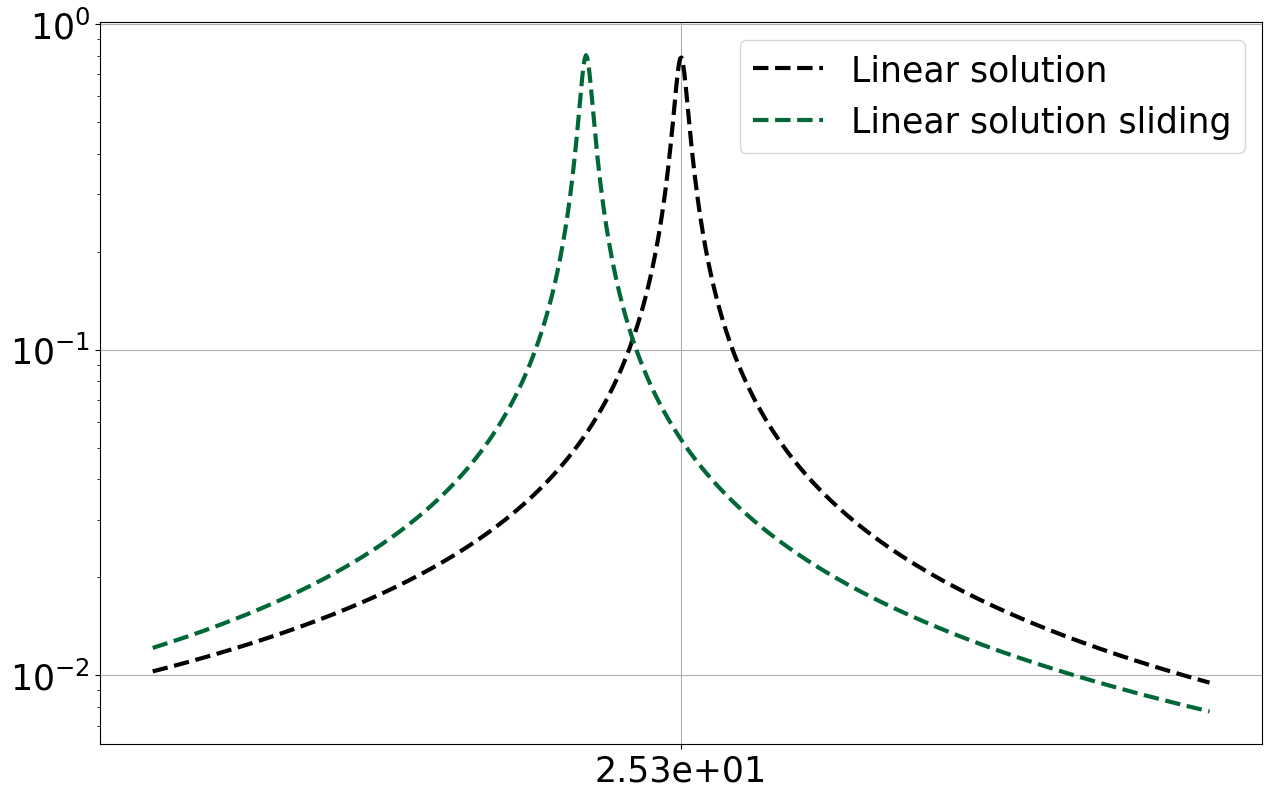

In [5]:
SA_lin_tm, om_lin_tm, amp_lin_tm = get_frf(Lin_tm)

fig,ax = prep_fig(np.array([puls_resonance]))
ax.plot(om_lin,amp_lin,**style_plots_ref["frf_lin"])
ax.plot(om_lin_tm,amp_lin_tm,**style_plots_ref["frf_lin_slide"])
ax.legend()

### 1.3 Full stick response

We can now consider the configuration when the added mass is stuck to the ground. It is equivalent to adding the linear spring directly from `sub1` to the ground without adding the new mass

- Complete the function `add_tuned_mass_spring` and run the analysis



In [6]:
from Tuto_005_IntroductionToFriction_correctionfunctions import add_tuned_mass_spring_corr
### USER MODIFICATIONS
def add_tuned_mass_spring(INP:dict,k_link:float)->dict:
    """Function that copies the input dictionary and returns a new one with the added linear spring
    - Add the linear spring connector between the original substructure and the ground by defining a
    single key,value in the "connect" argument
    """
    INP_new = copy.deepcopy(INP)
    ### modifications bellow
    ### end modifications
    return INP_new
### END 

INP_tms = add_tuned_mass_spring_corr(INP,rigid_tm)
Lin_tms = pyHarm.Maestro(INP_tms)
Lin_tms.operate()

solution converged at om=23.298221281347036
solution converged at om=23.30322128129157
solution converged at om=23.3082212812356
solution converged at om=23.31322128117912
solution converged at om=23.31822128112213
solution converged at om=23.323221281064622
solution converged at om=23.328221281006588
solution converged at om=23.33322128094802
solution converged at om=23.338221280888916
solution converged at om=23.343221280829273
solution converged at om=23.348221280769078
solution converged at om=23.35322128070833
solution converged at om=23.358221280647022
solution converged at om=23.363221280585147
solution converged at om=23.3682212805227
solution converged at om=23.37322128045973
solution converged at om=23.37822128039612
solution converged at om=23.383221280331913
solution converged at om=23.388221280267107
solution converged at om=23.393221280201697
solution converged at om=23.398221280135672
solution converged at om=23.40322128006903
solution converged at om=23.40822128000176
s

solution converged at om=24.25322124765503
solution converged at om=24.25822124719822
solution converged at om=24.263221246735093
solution converged at om=24.268221246265536
solution converged at om=24.273221245789447
solution converged at om=24.278221245306714
solution converged at om=24.283221244817227
solution converged at om=24.288221244320873
solution converged at om=24.293221243817534
solution converged at om=24.298221243307093
solution converged at om=24.30322124278943
solution converged at om=24.30822124226442
solution converged at om=24.313221241731938
solution converged at om=24.318221241191857
solution converged at om=24.323221240644045
solution converged at om=24.32822124008837
solution converged at om=24.333221239524697
solution converged at om=24.338221238952887
solution converged at om=24.3432212383728
solution converged at om=24.348221237784287
solution converged at om=24.353221237187206
solution converged at om=24.358221236581404
solution converged at om=24.36322123596

solution converged at om=25.203220505485216
solution converged at om=25.208220487324418
solution converged at om=25.21322046863467
solution converged at om=25.21822044939739
solution converged at om=25.223220429593223
solution converged at om=25.228220409202017
solution converged at om=25.233220388202774
solution converged at om=25.23822036657362
solution converged at om=25.24322034429176
solution converged at om=25.248220321333424
solution converged at om=25.25322029767383
solution converged at om=25.258220273287137
solution converged at om=25.263220248146375
solution converged at om=25.268220222223412
solution converged at om=25.273220195488875
solution converged at om=25.278220167912107
solution converged at om=25.28322013946108
solution converged at om=25.288220110102348
solution converged at om=25.29322007980096
solution converged at om=25.298220048520385
solution converged at om=25.30322001622243
solution converged at om=25.308219982867158
solution converged at om=25.313219948412

solution converged at om=26.17181249375159
solution converged at om=26.177013889855687
solution converged at om=26.182196843195783
solution converged at om=26.18736265646717
solution converged at om=26.192512589256417
solution converged at om=26.19764786340954
solution converged at om=26.202769662701048
solution converged at om=26.207879128772994
solution converged at om=26.212977355156347
solution converged at om=26.218065380864275
solution converged at om=26.22314418464631
solution converged at om=26.22821468058812
solution converged at om=26.23327771538699
solution converged at om=26.238334067356377
solution converged at om=26.243384447022486
solution converged at om=26.24842949906361
solution converged at om=26.253469805294696
solution converged at om=26.25850588839649
solution converged at om=26.26353821611485
solution converged at om=26.268567205696897
solution converged at om=26.2735932283776
solution converged at om=26.278616613775913
solution converged at om=26.283637654100485

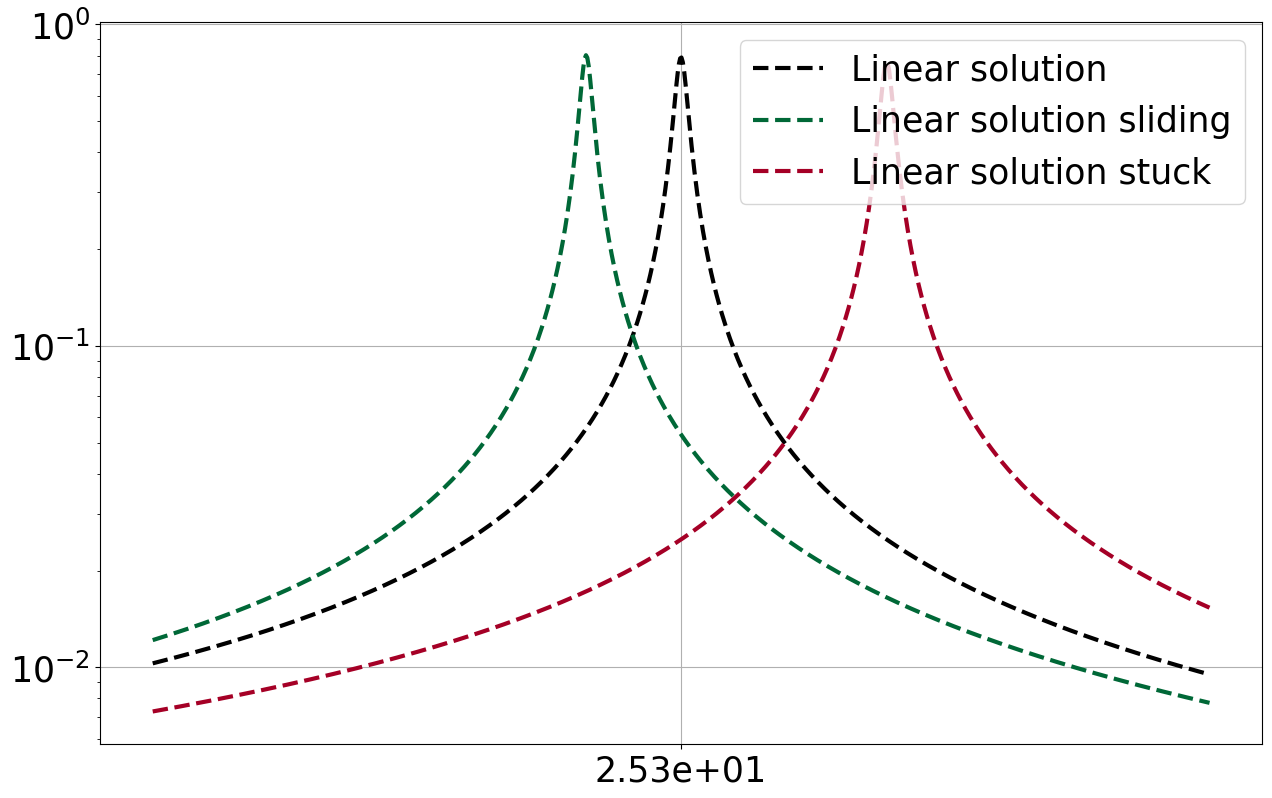

In [7]:
SA_lin_tms, om_lin_tms, amp_lin_tms = get_frf(Lin_tms)

fig,ax = prep_fig(np.array([puls_resonance]))
ax.plot(om_lin,amp_lin,**style_plots_ref["frf_lin"])
ax.plot(om_lin_tm,amp_lin_tm,**style_plots_ref["frf_lin_slide"])
ax.plot(om_lin_tms,amp_lin_tms,**style_plots_ref["frf_lin_stuck"])
ax.legend()

## 2. Build the smooth Coulomb friction element

### 2.1 Smooth Coulomb function

Friction contact is widely present in mechanical assemblies. Its presence is sometimes beneficial like in bolted joints that induce a damping effect on the vibration properties of an assembly to the point that it is sometimes added on purpose by the engineer in order to absorb vibration energy. The friction contact modeling has been studied through many years and one of the most well known contact models is the Coulomb model. 

In this part of the notebook we propose to implement a new nonlinear element that is a formulation of a friction contact model based on Coulomb formulation. The proposed model is sometimes called the smooth Coulomb model as it uses a function that tends to the initial Coulomb model when its regularization parameters tend to 0. The formulation is given by : 

$$f_{fric}(t) = - \mu N_{0} \tanh{(\frac{\dot{x}(t)}{\epsilon})}$$

- Complete the `smooth_friction` function that returns the value of the friction force using the previous equation

In [8]:
from Tuto_005_IntroductionToFriction_correctionfunctions import smooth_friction_corr
MU = 1.
N0 = 1. 
EPSILON_SAMPLE = 10**np.arange(0,-3,-1/3.).astype(float)
CMAP_EPSILON = cm.get_cmap("RdYlGn_r",len(EPSILON_SAMPLE))
XDOT_SAMPLES = 1001

### USER MODIFICATIONS
def smooth_friction(xdot,mu,n0,epsilon) : 
    """Function that computes the nonlinear forces using 
    the tanh regularization of Coulomb friction model."""
    f_fric = 0.
    return f_fric
### END


log_spacing = 10**np.linspace(-8,0,XDOT_SAMPLES//2).astype(float)
xdot_sampled = np.concatenate([-log_spacing[-1::-1],np.zeros(1),log_spacing])
fig,ax = plt.subplots(figsize=ratio_fig)
for k,epsilon in enumerate(EPSILON_SAMPLE) : 
    friction_force = smooth_friction_corr(xdot_sampled,MU,N0,epsilon)
    ax.plot(xdot_sampled,friction_force,
            color=CMAP_EPSILON(k), linewidth=3, label=f"$\epsilon={epsilon:.1e}$")
ax.set_xticks([])
ax.set_yticks([-MU*N0,MU*N0])
ax.set_yticklabels(["$-\mu N_{0}$","$\mu N_{0}$"])
ax.grid()
ax.legend()
ax.set_xlabel("$\dot{x}$")
ax.set_ylabel("$f_{fric}$")

Text(0, 0.5, '$f_{fric}$')

When the regularization parameter $\epsilon$ tends to $0$ the function converges towards the proper Coulomb description of the friction forces. 

In [9]:
from Tuto_005_IntroductionToFriction_correctionfunctions import residual_regulfriction_corr
from pyHarm.BaseUtilFuncs import pyHarm_plugin
from pyHarm.Elements.NodeToNodeElements.NodeToNodeElement import NodeToNodeElement
### USER MODIFICATIONS
def residual_regulfriction(x, om, Pslave, Pmaster, nabo, DFT, DTF,
                          mu, n0, epsilon) : 
    """
    This is the residual contribution of the smooth coulomb friction model made previously.
    - Construct the relative harmonic speed by applying (Pslave-Pmaster) operator on the dof vector and using the derivative operator nabo. 
    - Construct the relative time speed by applying the inverse Fourier operator
    - Apply the `smooth_friction` function coded earlier to the relative speed
    - Transform the force back into harmonic domain
    - Apply the force onto the right dofs by using (Pslave-Pmaster).T
    """
    force_fric_h = np.zeros(x.shape)
    return force_fric_h
### END


class RegularizedFriction(NodeToNodeElement): 
    """
    """
    factory_keyword = "regulfric"
    def __post_init__(self,):
        self.mu = self.data["mu"]
        self.N0 = self.data["N0"]
        self.epsilon = self.data["eps"]
        self.nabo = np.linalg.matrix_power(self.nabla,1) # derivation operator 

    def __flag_update__(self) : 
        self.flag_nonlinear = True
        self.flag_AFT = True
        
    def adim(self,):
        pass

    def evalResidual(self, xg, om):
        x = xg[self.indices]
        ### Below to switch from correction to your own function
        self.R = residual_regulfriction_corr(x, om, self.Pslave, self.Pmaster,
                                       self.nabo,self.D["ft"],self.D["tf"],
                                    self.mu,self.N0,self.epsilon)
        return self.R
    
    def evalJacobian(self, xg, om):
        self.J,self.dJdom = self._evalJaco_DF(xg, om, 1e-5)
        return self.J,self.dJdom

pyHarm_plugin(RegularizedFriction)

In [10]:
from Tuto_005_IntroductionToFriction_correctionfunctions import add_tuned_mass_plus_friction_corr

### USER MODIFICATIONS
def add_tuned_mass_plus_friction(INP,tuned_mass,k_link,mu,n0,epsilon,add_tuned_mass):
    """
    Function that adds the friction element to the input dictionary.
    - Use previous `add_tuned_mass` function
    - Complete the new input dictionary by adding the friction element
    """
    ### modifications bellow
    INP_new = copy.deepcopy(INP) # use the previous function to generate new dictionary
    ### end modifications
    return INP_new
### END 


In [11]:
MU = 1.
EPSILON_TM = 5e-2
N0_samp = 10**np.linspace(-.5,1.5,10).astype(float)

om_f = dict()
amp_f = dict()
for k,n0 in enumerate(N0_samp):
    # change to your function below (you can also change the argument add_tuned_mass_corr)
    INP_tm_f = add_tuned_mass_plus_friction_corr(INP,TunedMass,rigid_tm,MU,n0,EPSILON_TM,add_tuned_mass_corr) 
    INP_tm_f["analysis"]["FRF"]["verbose"] = False
    INP_tm_f["analysis"]["FRF"]["ds_max"] *= 2
    Lin_tm_f = pyHarm.Maestro(INP_tm_f)
    Lin_tm_f.operate()
    print(f"Analysis for N_{0}={n0:.1e} over in {Lin_tm_f.timetosolve:.1f}s")
    SA_lin_tm_f, om_lin_tm_f, amp_lin_tm_f = get_frf(Lin_tm_f)
    om_f[n0] = copy.deepcopy(om_lin_tm_f)
    amp_f[n0] = copy.deepcopy(amp_lin_tm_f)
    


Analysis for N_0=3.2e-01 over in 2.1s
Analysis for N_0=5.3e-01 over in 2.1s
Analysis for N_0=8.8e-01 over in 1.9s
Analysis for N_0=1.5e+00 over in 1.9s
Analysis for N_0=2.4e+00 over in 1.9s
Analysis for N_0=4.1e+00 over in 1.9s
Analysis for N_0=6.8e+00 over in 1.9s
Analysis for N_0=1.1e+01 over in 1.9s
Analysis for N_0=1.9e+01 over in 1.9s
Analysis for N_0=3.2e+01 over in 1.9s


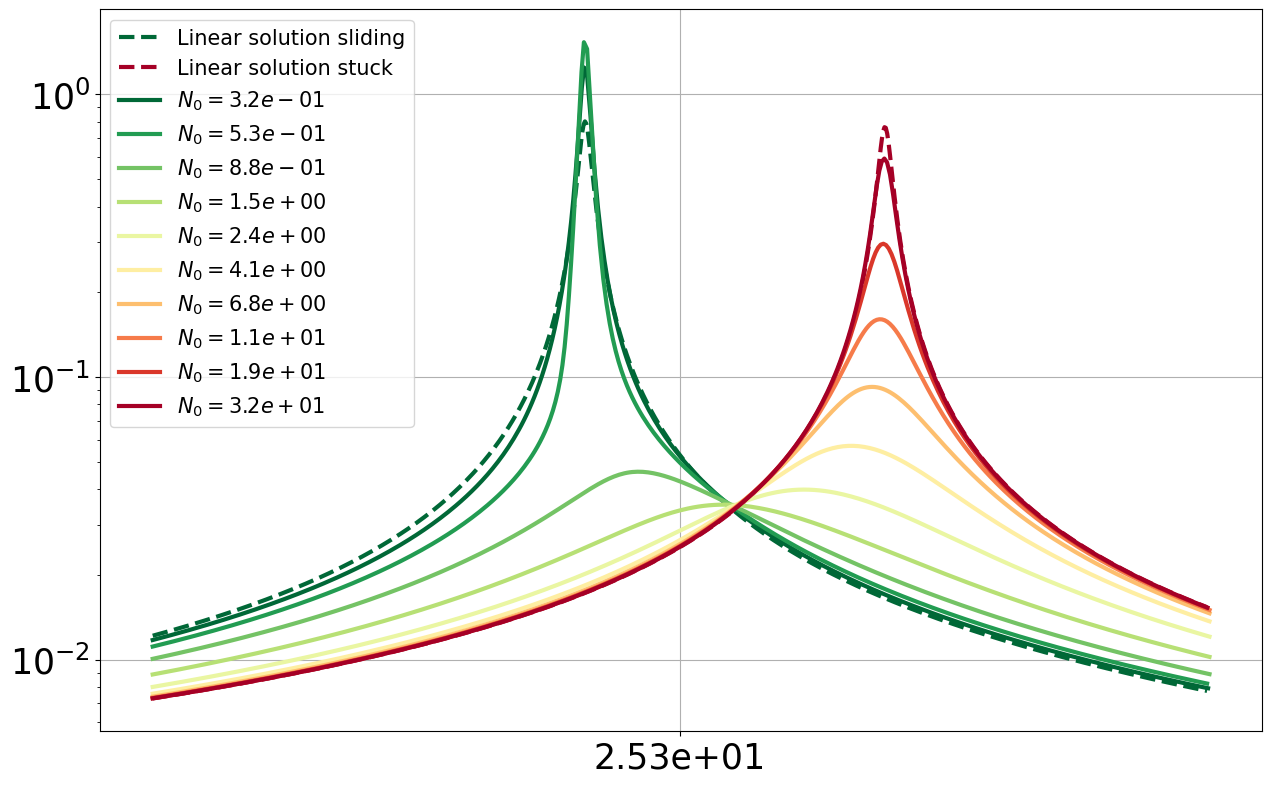

In [12]:

CMAP_N0 = cm.get_cmap("RdYlGn_r",len(N0_samp))
fig,ax = prep_fig(np.array([puls_resonance]))
ax.plot(om_lin_tm,amp_lin_tm,**style_plots_ref["frf_lin_slide"])
ax.plot(om_lin_tms,amp_lin_tms,**style_plots_ref["frf_lin_stuck"])
for k,n0 in enumerate(N0_samp):
    ax.plot(om_f[n0],amp_f[n0],color=CMAP_N0(k),linewidth=3,
           label=f"$N_{0}={n0:.1e}$")
ax.set_yscale("log")
ax.legend(fontsize=15)

By playing with the friction parameters we are able to damp the initial structure by a great amount 

- For the previous analysis, choose a $\mu$ and $N_{0}$
- Proceed to a sweep in the forcing amplitude to see the evolution of the efficiency of the friction damper when the forcing varies by completing the `modify_forcing` function.

In [13]:
### USER MODIFICATIONS 
MU_CHOSEN = 1. # base is 1. 
N0_CHOSEN = 5. # base is 5.
### END

# change to your function below (last argument as well)
INP_FRICTION = add_tuned_mass_plus_friction_corr(INP,TunedMass,rigid_tm,MU_CHOSEN,N0_CHOSEN,EPSILON_TM,
                                                 add_tuned_mass_corr)

### USER MODIFICATIONS 
def modify_forcing(INP:dict,forcing_coef:float) -> dict:
    """
    Function that modifies the amplitude of the forcing into the input dictionary
    - Make a copy of the input dictionary
    - forcing_new = forcing_old * forcing_coef
    """
    ### modifications bellow
    INP_new = copy.deepcopy(INP)
    ### end modifications
    return INP_new
### END


In [14]:
from Tuto_005_IntroductionToFriction_correctionfunctions import modify_forcing_corr
FORCING_samp = np.concatenate([10**np.linspace(.93,.8,10).astype(float),
                               10**np.linspace(.7,-.3,5).astype(float)])

om_fc = dict()
amp_fc = dict()
for k,forcing_coef in enumerate(FORCING_samp):
    INP_tm_fc = modify_forcing_corr(INP_FRICTION,forcing_coef) # change to your function
    INP_tm_fc["analysis"]["FRF"]["verbose"] = False
    INP_tm_fc["analysis"]["FRF"]["ds_max"] *= 2
    Lin_tm_fc = pyHarm.Maestro(INP_tm_fc)
    Lin_tm_fc.operate()
    forcing_val = INP_tm_fc["connectors"]["loading"]["amp"]
    print(f"Analysis for Forcing={forcing_val:.1e} over in {Lin_tm_fc.timetosolve:.1f}s")
    SA_lin_tm_fc, om_lin_tm_fc, amp_lin_tm_fc = get_frf(Lin_tm_fc)
    om_fc[forcing_coef] = copy.deepcopy(om_lin_tm_fc)
    amp_fc[forcing_coef] = copy.deepcopy(amp_lin_tm_fc)
    


Analysis for Forcing=8.5e+00 over in 3.1s
Analysis for Forcing=8.2e+00 over in 2.3s
Analysis for Forcing=8.0e+00 over in 1.9s
Analysis for Forcing=7.7e+00 over in 1.9s
Analysis for Forcing=7.5e+00 over in 1.9s
Analysis for Forcing=7.2e+00 over in 1.9s
Analysis for Forcing=7.0e+00 over in 1.9s
Analysis for Forcing=6.7e+00 over in 1.9s
Analysis for Forcing=6.5e+00 over in 1.9s
Analysis for Forcing=6.3e+00 over in 1.9s
Analysis for Forcing=5.0e+00 over in 1.9s
Analysis for Forcing=2.8e+00 over in 1.9s
Analysis for Forcing=1.6e+00 over in 1.9s
Analysis for Forcing=8.9e-01 over in 1.9s
Analysis for Forcing=5.0e-01 over in 1.9s


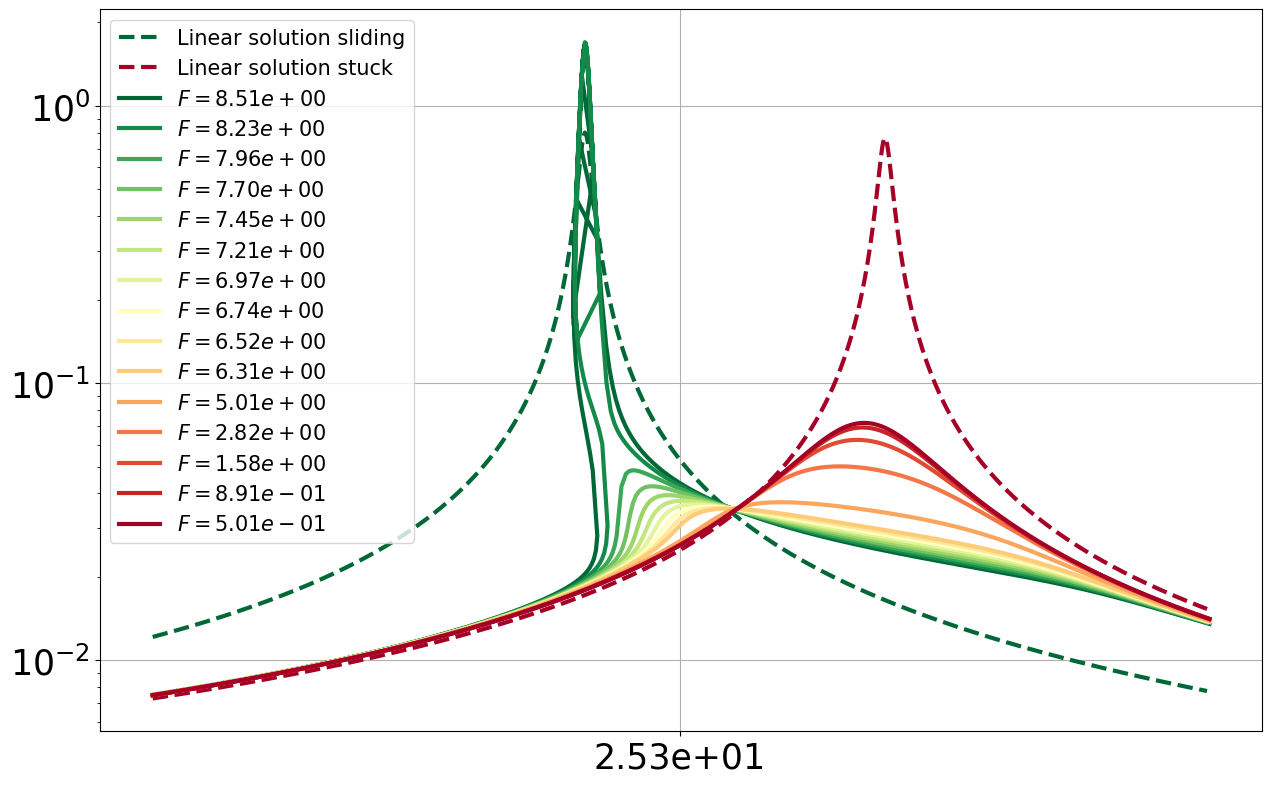

In [15]:
CMAP_FORCING = cm.get_cmap("RdYlGn_r",len(FORCING_samp))
fig,ax = prep_fig(np.array([puls_resonance]))
ax.plot(om_lin_tm,amp_lin_tm,**style_plots_ref["frf_lin_slide"])
ax.plot(om_lin_tms,amp_lin_tms,**style_plots_ref["frf_lin_stuck"])
for k,forcing_coef in enumerate(FORCING_samp):
    ax.plot(om_fc[forcing_coef],amp_fc[forcing_coef]/forcing_coef,color=CMAP_FORCING(k),linewidth=3,
           label=f"$F={forcing_coef:.2e}$")
ax.set_yscale("log")
ax.legend(fontsize=15)

The damper remains efficient until a certain threshold is reached. After the threshold is reached the damper goes to a slip configuration and its efficiency drops completly. This shows the importance of the need for extra care when designing such a damper. If the running conditions are not studied carefully, the damper might have no effect besides modifying the resonance frequency. 

## Conclusion 

In this notebook  an introduction to friction mechanisms has been made through the use of smooth Coulomb friction model. This modeling has allowed to evaluate the efficiency of a friction based damper over a single mass system. The friction is quite sensitive to the loading thus implying that it is important to master the running conditions before designing those devices. 

In the next tutorial, a study of a friction ring damper is proposed onto a full bladed disk modeled using a lumped modeling.